# Using gradient descent for linear regression

## Preamble

In [77]:
### you might need
#! pip install scikit-learn

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tqdm

In [79]:
plt.rcParams["figure.figsize"] = (8,6)

In [80]:
%matplotlib widget

## 1) Create a funky and noisy dataset

$y = b + 0.02x +  \frac{3}{10} sin(x) + 
\frac{1}{10} \Big( log(x) \Big)^2 + \epsilon$,
 
where $\epsilon$ is a random number

In [81]:
N_data = 5000
epsilon = 0.1*np.random.randn(N_data,1)

data_x = np.linspace(1.0, 50.0, N_data)[:, np.newaxis]
data_y = 1.5 + 0.02*data_x + 0.3*np.sin(data_x) + 1e-1  * np.log( data_x ) **2 + epsilon
#data_y = data_x + 0.1*np.random.randn(N_data,1)

In [82]:
data_x.shape, data_y.shape

((5000, 1), (5000, 1))

### Note that X is a _column_ vector

In [83]:
data_x

array([[ 1.        ],
       [ 1.00980196],
       [ 1.01960392],
       ...,
       [49.98039608],
       [49.99019804],
       [50.        ]])

Text(0, 0.5, 'temperature')

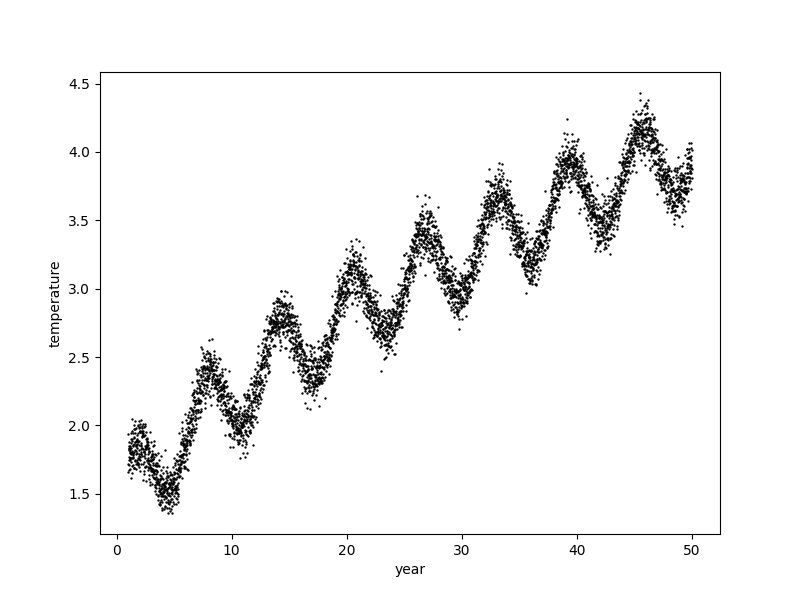

In [84]:
fig, ax = plt.subplots()
ax.scatter(data_x.flatten(), data_y.flatten(), s=0.5, color='black')
ax.set_xlabel('year')
ax.set_ylabel('temperature')


## 2) Make a train-test split of the available dataset

In [85]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

In [86]:
X_train.shape, y_train.shape

((4000, 1), (4000, 1))

## 3) A simple gradient descent model

In [87]:
class LinearRegression:
    def __init__(self, X, y, lr=1e-4, tolerance=0.05):

        self.lr = lr                                # learning rate
        self.tolerance = tolerance                  # when to consider convergence
        self.n_samples = len(y)
        self.n_features = X.shape[1]                # in this example we just use 1-dimensional input features
        self.X = X                                  # input features
        self.y = y                                  # target values
        self.W = np.random.randn(self.n_features,1) # randomly initialize weights
        self.b = np.random.randn(1,1)               # randomly initialize bias
        self.loss_history = []
        self.W_history = []
        self.b_history = []

    def predict(self, X) : 

        y_pred = np.dot(X, self.W)  + self.b
        return y_pred

    def calc_loss(self, y_targ, y_pred):

        ### Mean-squared-error loss (a.k.a. MSE or L2 loss)
        return 0.5 * np.mean( (y_pred - y_targ)**2 )

    def calc_gradients(self,y_pred):

        grad_W = np.mean((y_pred - self.y)*X_train)
        grad_b = np.mean( y_pred - self.y)
        return grad_W, grad_b

    def update_params(self, grad_W, grad_b):

        self.W = self.W - self.lr * grad_W.T
        self.b = self.b - self.lr * grad_b

    def reset(self):
            
            self.W = np.random.randn(self.n_features,1)
            self.b = np.random.randn(1,1)
            self.loss_history = []
            self.W_history = []
            self.b_history = []

    def train(self, n_iter=1500): 

        self.reset()
        loss = np.inf

        progress_bar = tqdm.tqdm(range(n_iter))
        for i in progress_bar:

            y_pred = self.predict(self.X)

            loss = self.calc_loss(self.y, y_pred)
            self.loss_history.append(loss)
            self.W_history.append(self.W.flatten())
            self.b_history.append(self.b.flatten())

            grad_W, grad_b = self.calc_gradients(y_pred)

            # check if the gradient is smaller than desired precision
            if loss < self.tolerance:
               break

            self.update_params(grad_W,grad_b)
            # progress_bar.set_description(f'Loss: {loss:.4f}') # <-- somehow this slow?!

        self.loss_history = np.array(self.loss_history)
        self.W_history = np.hstack(self.W_history)
        self.b_history = np.hstack(self.b_history)

        if i == n_iter-1:
            print(f'Warning: Training did not converge within {n_iter} iterations.  Try increasing!')
        else:
            print(f'Converged at iteration {i}')
            print(f'Final loss: {loss}')
            print(f'Final W: {self.W}')
            print(f'Final b: {self.b}')

        return loss, self.W.flatten()[0], self.b.flatten()[0]
    


In [88]:
model = LinearRegression(X_train, y_train)

## 4) Train the model on the X-y pair data

In [89]:
best_loss, best_W, best_b = model.train(n_iter=100000)

 85%|████████▍ | 84749/100000 [00:02<00:00, 35403.69it/s]


Converged at iteration 84749
Final loss: 0.04999958522113279
Final W: [[0.05976315]]
Final b: [[1.35478216]]


Text(0, 0.5, 'log(loss)')

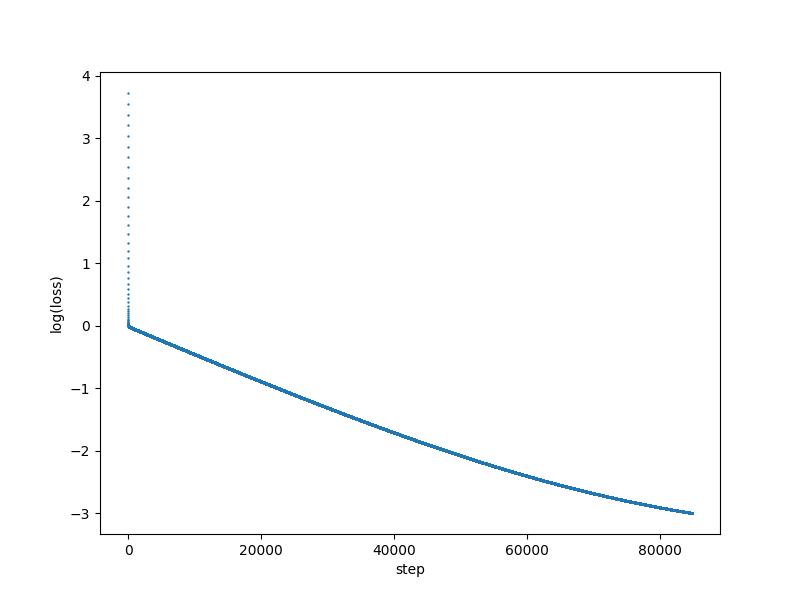

In [90]:
fig, ax = plt.subplots()
ax.scatter(range(len(model.loss_history)), np.log(model.loss_history), s=0.5)
ax.set_xlabel('step')
ax.set_ylabel('log(loss)')

## 4) Plot the loss landscape near the solution

In [91]:
N_points = 2000

# make a grid of values in the area containing the history of W and b
W_dynamic_range = np.max(model.W_history) - np.min(model.W_history)
b_dynamic_range = np.max(model.b_history) - np.min(model.b_history)

W_grid = np.mean(model.W_history) + 1.1*np.linspace(-W_dynamic_range, W_dynamic_range, N_points)
b_grid = np.mean(model.b_history) + 1.1*np.linspace(-b_dynamic_range, b_dynamic_range, N_points)

W_grid, b_grid = np.meshgrid(W_grid, b_grid)
loss_grid = np.zeros_like(W_grid)

# Note: this can be done much faster with numpy :o
for i in tqdm.tqdm(range(W_grid.shape[0])):
    for j in range(W_grid.shape[1]):
        model.W[0,0] = W_grid[i,j]
        model.b[0,0] = b_grid[i,j]
        loss_grid[i,j] = model.calc_loss(y_train, model.predict(X_train))

100%|██████████| 2000/2000 [00:49<00:00, 40.57it/s]


/var/folders/40/2yzrw8k93wdctqr9dxlvkrfh0000gn/T/ipykernel_52230/289491607.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


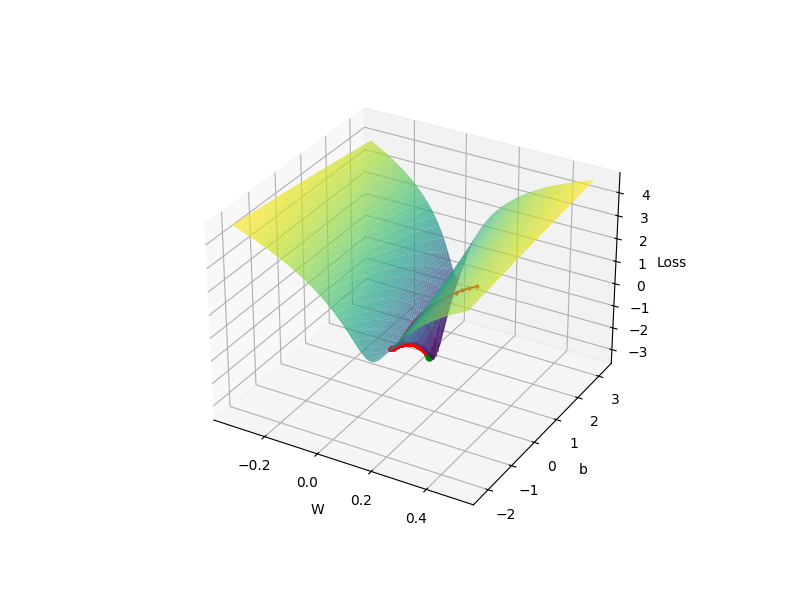

In [92]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# the loss landscape
ax.plot_surface(W_grid, b_grid, np.log(loss_grid), cmap='viridis', edgecolor='none', alpha=0.7)

# the history of W and b values
ax.plot(model.W_history, model.b_history, np.log(model.loss_history), marker='o', color='red', markersize=2)

# the final W and b values
ax.plot([best_W], [best_b], np.log(best_loss), marker='o', color='green', markersize=5)

ax.set_xlabel('W')
ax.set_ylabel('b')
ax.set_zlabel('Loss')
plt.show()

## 5) Evaluate model performance on _independent_ test dataset

In [93]:
model.W = np.array([[best_W]])
model.b = np.array([[best_b]])

In [94]:
y_pred = model.predict(X_test)

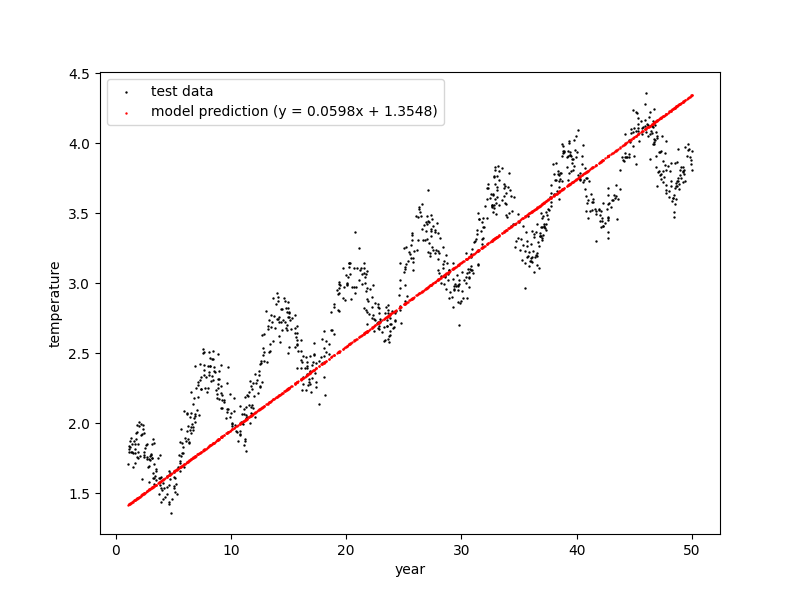

In [95]:
fig, ax = plt.subplots()
ax.scatter(X_test.flatten(), y_test.flatten(), s=0.5, color='black', label='test data')
ax.set_xlabel('year')
ax.set_ylabel('temperature')
ax.scatter(X_test.flatten(), y_pred.flatten(), s=0.5, color='red', label='model prediction (y = {:.4f}x + {:.4f})'.format(float(model.W[0,0]), float(model.b[0,0]) ))
ax.legend()


### 6) Bonus: X has 2 input features

In [96]:
# make a new dataset which has 2 input features
# let's give the model the chance to use sin(x) since that should help
data_x2 = np.hstack([data_x, np.sin(data_x)])
X_train2, X_test2, y_train2, y_test2 = train_test_split(data_x2, data_y, test_size=0.2, random_state=42)

In [97]:
# Now the input data have 2 features for each example
print(X_train2)

[[ 4.24328866e+01 -9.99771333e-01]
 [ 4.68339668e+01  2.85878450e-01]
 [ 8.84156831e+00  5.50705859e-01]
 ...
 [ 3.13076615e+01 -1.08053626e-01]
 [ 3.79729946e+01  2.70471504e-01]
 [ 9.42968594e+00 -4.90795671e-03]]


In [98]:
model2 = LinearRegression(X_train2, y_train2, lr=1e-4, tolerance=0.05)

In [99]:
# train the model2
best_loss2, best_W2, best_b2 = model2.train(n_iter=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:03<00:00, 26084.47it/s]

In [100]:
y_pred2 = model2.predict(X_test2)

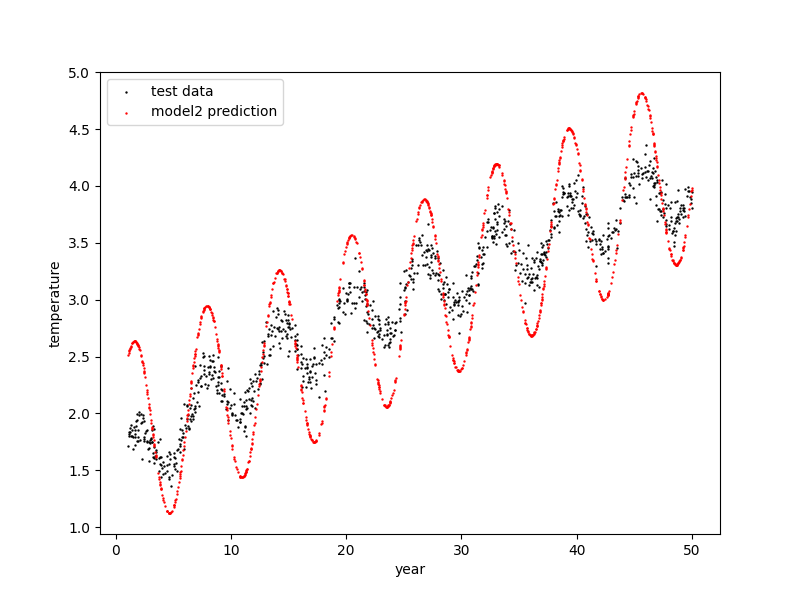

In [101]:
fig, ax = plt.subplots()
ax.scatter(X_test2[:,0], y_test2, s=0.5, color='black', label='test data')
ax.set_xlabel('year')
ax.set_ylabel('temperature')
ax.scatter(X_test2[:,0], y_pred2, s=0.5, color='red', label='model2 prediction')
ax.legend()